In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from implementations import *
from helpers import *
from Model import *

In [2]:
[yb_t, input_data_t, ids_t, yb_test, input_data_test, ids_test] = pickle.load(open( "dat.p", "rb" ))
input_clean = clean_data(input_data_t)
test_clean = clean_data(input_data_test)

In [3]:
def replaceByMeanPerFeature(input_tx_train, input_y_train, input_tx_test, input_y_test):
    train_mean = np.nanmean(input_tx_train, axis=0) # Computes the mean per column without considering nan value
    for ind, mean in enumerate(train_mean):
        mask_tmp = np.isnan(input_tx_train[:,ind])
        input_tx_train[mask_tmp, ind] = mean
        mask_tmp = np.isnan(input_tx_test[:,ind])
        input_tx_test[mask_tmp, ind] = mean
    y_train = input_y_train
    y_test = input_y_test
    return input_tx_train, y_train, input_tx_test, y_test


In [4]:
input_tx_train, y_train, input_tx_test, y_test = replaceByMeanPerFeature(input_clean, yb_t, test_clean, yb_test)

tx_std, mean_x, std_x = standardize(input_tx_train)

tx_te_std = (input_tx_test-mean_x) / std_x

In [21]:
%%time
from cross_val import *

#SGD.fit(y_train, tx_std)
lambdas = np.logspace(-20, 10, 30)
losses_tr = []
losses_te = []
for lambda_ in lambdas:
    mod = ridge_regression(lambda_)
    loss_tr, loss_te = cross_validation(mod,y_train,input_tx_train, 5)
    losses_tr.append(np.mean(loss_tr))
    losses_te.append(np.mean(loss_te))

Wall time: 13.2 s


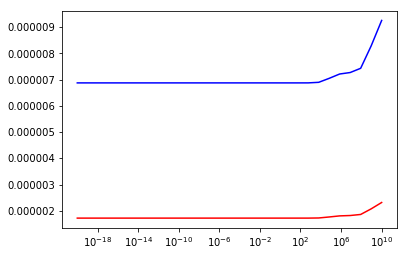

In [22]:
%matplotlib inline
plt.figure()
plt.semilogx(lambdas, losses_tr, 'r')
plt.semilogx(lambdas, losses_te, 'b')
plt.show()

In [24]:
ridge = ridge_regression(10)
ridge.fit(y_train, tx_std)
y_pred_test = ridge.predict(tx_te_std)

In [31]:
y_pred_bin = np.array([-1 if p<0 else 1 for p in y_pred_test])
np.sum(y_pred_bin)

-308612

In [33]:
create_csv_submission(ids_test, y_pred_test, 'sub2.csv')

In [34]:
create_csv_submission(ids_test, y_pred_bin, 'sub3.csv')